Exercise 1 <br>
0. Modul Imports

In [2]:
import os
import io
import math
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import scikitplot as skplt
import matplotlib.pyplot as plt

1. Prepare the given data and store the labels

In [5]:
# Read the input data into a table
df = pd.read_table('SAKI Exercise 1 - Transaction Classification - Data Set.csv', sep=';')
# Put label column in a separat pandas dataframe
labels = pd.DataFrame(data=df['label'])
df.head()

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


2. Extract the relevant features. In this case I choose 'Auftragskonto', 'Buchungstag', 'Buchungstext', 'Verwendungszweck', 'Kontonummer', 'BLZ' and 'Betrag'.
Prepare and transform the features so that we can work with them

In [24]:
# Feature Auftragskonto just us it direct as a feature
features_auftragskonto = pd.get_dummies(df['Auftragskonto'])

# Feature Buchungstag => extract day of the week and week of the month 
# convert column values to datetime
buchungstag = pd.to_datetime(df['Buchungstag'])
day_of_the_week = buchungstag.dt.dayofweek

# calculate the week in the month and use this as an additional feature
# (this is a relatively weak feature)
week_of_the_month = pd.to_numeric(buchungstag.dt.day/7).apply(lambda x: math.ceil(x))
day_of_the_week = pd.get_dummies(day_of_the_week)
week_of_the_month = pd.get_dummies(week_of_the_month)
# combine day of the week and week of the month as Buchungstag features
features_buchungstag = pd.concat([week_of_the_month, day_of_the_week], axis=1)

# Feature Buchungstext just use the whole word as a feature
features_buchungstext = pd.get_dummies(df['Buchungstext'])

# Bag of words for Verwendungszweck
# Optional with german stopwords, but this did not bring any further improvement
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# german_stop_words = stopwords.words('german')
# count_vector = CountVectorizer(stop_words=german_stop_words)
count_vector = CountVectorizer()
use_case = df['Verwendungszweck']
count_vector.fit(use_case)
names = count_vector.get_feature_names()

# frequency matrix of the words
use_case_array = count_vector.transform(use_case).toarray()
features_use_case = pd.DataFrame(data=use_case_array, columns=names)

# Feature Kontonummer just us it direct as a feature
features_kontonummer = pd.get_dummies(df['Kontonummer'])

# Feature BLZ just us it direct as a feature
features_blz =  pd.get_dummies(df['BLZ'])

# Features Betrag => use the value and if it is a positive or negative value
betraege = df['Betrag']
str_betraege = betraege.apply(lambda x: x.replace(',','.'))
betraege = pd.to_numeric(str_betraege)
pos_neg = (betraege >= 0) * 1
features_betrag = pd.get_dummies(pd.concat([df['Betrag'], pos_neg], axis=1))

# combine all features to train and test the model:
features = pd.concat([features_auftragskonto, features_buchungstag, features_buchungstext, features_use_case,
                      features_kontonummer, features_blz, features_betrag], axis=1)

3. Split data and train the model, scale features

In [25]:
# Split data into test and training set
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)

# Scale all the features 
# (scaling is not used for cross validation in the evaluation, only for the other metrics)
# (scaling is optional, but bring slight performance increase ~1%)
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

classifier = GaussianNB()
classifier.fit(x_train, y_train.values.ravel())

# Predict based on the data
predictions = classifier.predict(x_test)
print(predictions)

['finance' 'finance' 'leisure' 'standardOfLiving' 'living' 'private'
 'finance' 'standardOfLiving' 'living' 'private' 'private' 'leisure'
 'finance' 'standardOfLiving' 'finance' 'leisure' 'standardOfLiving'
 'standardOfLiving' 'finance' 'income' 'standardOfLiving' 'private'
 'private' 'standardOfLiving' 'income' 'leisure' 'living' 'income'
 'living' 'leisure' 'leisure' 'income' 'income' 'income'
 'standardOfLiving' 'standardOfLiving' 'standardOfLiving'
 'standardOfLiving' 'finance' 'standardOfLiving' 'leisure' 'leisure'
 'standardOfLiving' 'standardOfLiving' 'leisure' 'private'
 'standardOfLiving' 'living' 'leisure' 'private' 'leisure' 'income'
 'leisure' 'finance' 'standardOfLiving' 'leisure' 'leisure' 'private'
 'finance' 'leisure' 'finance' 'leisure' 'finance']


4. Evaluate the model

In [30]:
# Evaluate the model with multiple metrics
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))

print('Precision score: ', format(precision_score(y_test, predictions, average='weighted')))

print('Recall score: ', format(recall_score(y_test, predictions, average='weighted')))

print('F1 score: ', format(f1_score(y_test, predictions, average='weighted')))

# Cross validation
# ShuffleSplit for more precise cross validation
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(classifier, features, labels.values.ravel(), cv=cv)
print('Cross_val_score: ', format (scores))
print('Cross_val_score mean: ', scores.mean())

Accuracy score:  0.9682539682539683
Precision score:  0.9692460317460317
Recall score:  0.9682539682539683
F1 score:  0.96816491907656
Cross_val_score:  [0.92063492 0.92063492 0.95238095 0.93650794 0.96825397]
Cross_val_score mean:  0.9396825396825397


5. Visualize the results with a confusion matrix

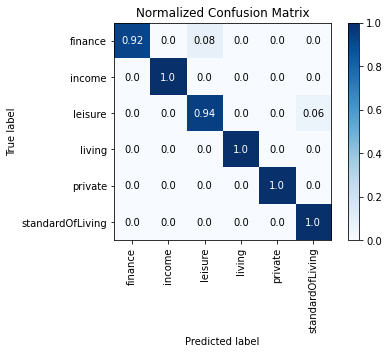

In [27]:
# Plot a confucsion matrix based on the predictions
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.xticks(rotation=90)
plt.show()